This file does an EDA based on the MAL dataset, then cleans it further and adds extra parameters as needed.  It then writes a train/eval set and a test set with an 80/20 split.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
sns.set()

import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

In [2]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

Data will be the full MAL list, 20% split off to be test data

In [3]:
mal_raw_df = pd.read_pickle('data\\mal_full\\mal_full_list.pkl')

np.random.seed(42)
df_mask = np.random.rand(len(mal_raw_df)) < 0.8

mal_df = mal_raw_df[df_mask]
mal_fortest_df = mal_raw_df[~df_mask]

In [4]:
mal_raw_df

Title  \
0                       Fullmetal Alchemist: Brotherhood   
1                                            Steins;Gate   
2                                               Gintama°   
3                                 Hunter x Hunter (2011)   
4                                   Ginga Eiyuu Densetsu   
...                                                  ...   
16701  Violence Gekiga Shin David no Hoshi: Inma Dens...   
16702                    W-Tails Cat: A Strange Presence   
16703               Yarichin Kateikyoushi Netori Houkoku   
16704                   Yasuji no Pornorama: Yacchimae!!   
16705                        Yuutousei Ayaka no Uraomote   

                                                     URL  \
0      https://myanimelist.net/anime/5114/Fullmetal_A...   
1         https://myanimelist.net/anime/9253/Steins_Gate   
2           https://myanimelist.net/anime/28977/Gintama°   
3      https://myanimelist.net/anime/11061/Hunter_x_H...   
4      https://myanimelist.net/anime/820/Ginga_Eiyuu_...   
...                                                  ...   
16701  https://myanimelist.net/anime/6133/Violence_Ge...   
16702  https://myanimelist.net/anime/20261/W-Tails_Ca...   
16703  https://myanimelist.net/anime/41260/Yarichin_K...   
16704  https://myanimelist.net/anime/26081/Yasuji_no_...   
16705  https://myanimelist.net/anime/41396/Yuutousei_...   

                                English  \
0      Fullmetal Alchemist: Brotherhood   
1                           Steins;Gate   
2                      Gintama Season 4   
3                       Hunter x Hunter   
4         Legend of the Galactic Heroes   
...                                 ...   
16701                               NaN   
16702                               NaN   
16703                               NaN   
16704                               NaN   
16705                               NaN   

                                                Synonyms  \
0      Hagane no Renkinjutsushi: Fullmetal Alchemist,...   
1                                                    NaN   
2                                        Gintama' (2015)   
3                                             HxH (2011)   
4      LoGH, LotGH, Gin'eiden, GinEiDen, Heldensagen ...   
...                                                  ...   
16701                                                NaN   
16702                    W Tails Cat: A Strange Presence   
16703                                                NaN   
16704  Do It! Yasuji's Pornorama, Yasuji''s Pornorama...   
16705                                                NaN   

                               Japanese   Type  Episodes           Status  \
0            鋼の錬金術師 FULLMETAL ALCHEMIST     TV      64.0  Finished Airing   
1                           STEINS;GATE     TV      24.0  Finished Airing   
2                                   銀魂°     TV      51.0  Finished Airing   
3              HUNTER×HUNTER（ハンター×ハンター）     TV     148.0  Finished Airing   
4                                銀河英雄伝説    OVA     110.0  Finished Airing   
...                                 ...    ...       ...              ...   
16701             バイオレンス劇画 新・堕靡泥の星 淫魔伝説    OVA       1.0  Finished Airing   
16702  W・TAILS CAT - A STRANGE PRESENCE    ONA       7.0  Finished Airing   
16703                     ヤリチン家庭教師ネトリ報告    OVA       2.0    Not yet aired   
16704                 ヤスジのポルノラマ やっちまえ!!  Movie       1.0  Finished Airing   
16705                      優等生 綾香のウラオモテ    OVA       NaN    Not yet aired   

                             Aired    Premiered  ...  \
0       Apr 5, 2009 to Jul 4, 2010  Spring 2009  ...   
1      Apr 6, 2011 to Sep 14, 2011  Spring 2011  ...   
2      Apr 8, 2015 to Mar 30, 2016  Spring 2015  ...   
3      Oct 2, 2011 to Sep 24, 2014    Fall 2011  ...   
4      Jan 8, 1988 to Mar 17, 1997          NaN  ...   
...                            ...          ...  ...   
16701                  Mar 8, 1991          NaN  ...  

In [5]:
mal_df

Title  \
0                       Fullmetal Alchemist: Brotherhood   
2                                               Gintama°   
3                                 Hunter x Hunter (2011)   
4                                   Ginga Eiyuu Densetsu   
5                                               Gintama'   
...                                                  ...   
16701  Violence Gekiga Shin David no Hoshi: Inma Dens...   
16702                    W-Tails Cat: A Strange Presence   
16703               Yarichin Kateikyoushi Netori Houkoku   
16704                   Yasuji no Pornorama: Yacchimae!!   
16705                        Yuutousei Ayaka no Uraomote   

                                                     URL  \
0      https://myanimelist.net/anime/5114/Fullmetal_A...   
2           https://myanimelist.net/anime/28977/Gintama°   
3      https://myanimelist.net/anime/11061/Hunter_x_H...   
4      https://myanimelist.net/anime/820/Ginga_Eiyuu_...   
5             https://myanimelist.net/anime/9969/Gintama   
...                                                  ...   
16701  https://myanimelist.net/anime/6133/Violence_Ge...   
16702  https://myanimelist.net/anime/20261/W-Tails_Ca...   
16703  https://myanimelist.net/anime/41260/Yarichin_K...   
16704  https://myanimelist.net/anime/26081/Yasuji_no_...   
16705  https://myanimelist.net/anime/41396/Yuutousei_...   

                                English  \
0      Fullmetal Alchemist: Brotherhood   
2                      Gintama Season 4   
3                       Hunter x Hunter   
4         Legend of the Galactic Heroes   
5                      Gintama Season 2   
...                                 ...   
16701                               NaN   
16702                               NaN   
16703                               NaN   
16704                               NaN   
16705                               NaN   

                                                Synonyms  \
0      Hagane no Renkinjutsushi: Fullmetal Alchemist,...   
2                                        Gintama' (2015)   
3                                             HxH (2011)   
4      LoGH, LotGH, Gin'eiden, GinEiDen, Heldensagen ...   
5                                         Gintama (2011)   
...                                                  ...   
16701                                                NaN   
16702                    W Tails Cat: A Strange Presence   
16703                                                NaN   
16704  Do It! Yasuji's Pornorama, Yasuji''s Pornorama...   
16705                                                NaN   

                               Japanese   Type  Episodes           Status  \
0            鋼の錬金術師 FULLMETAL ALCHEMIST     TV      64.0  Finished Airing   
2                                   銀魂°     TV      51.0  Finished Airing   
3              HUNTER×HUNTER（ハンター×ハンター）     TV     148.0  Finished Airing   
4                                銀河英雄伝説    OVA     110.0  Finished Airing   
5                                   銀魂'     TV      51.0  Finished Airing   
...                                 ...    ...       ...              ...   
16701             バイオレンス劇画 新・堕靡泥の星 淫魔伝説    OVA       1.0  Finished Airing   
16702  W・TAILS CAT - A STRANGE PRESENCE    ONA       7.0  Finished Airing   
16703                     ヤリチン家庭教師ネトリ報告    OVA       2.0    Not yet aired   
16704                 ヤスジのポルノラマ やっちまえ!!  Movie       1.0  Finished Airing   
16705                      優等生 綾香のウラオモテ    OVA       NaN    Not yet aired   

                             Aired    Premiered  ...  \
0       Apr 5, 2009 to Jul 4, 2010  Spring 2009  ...   
2      Apr 8, 2015 to Mar 30, 2016  Spring 2015  ...   
3      Oct 2, 2011 to Sep 24, 2014    Fall 2011  ...   
4      Jan 8, 1988 to Mar 17, 1997          NaN  ...   
5      Apr 4, 2011 to Mar 26, 2012  Spring 2011  ...   
...                            ...          ...  ...   
16701                  Mar 8, 1991          NaN  ...  

In [6]:
mal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13378 entries, 0 to 16705
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Title                13378 non-null  object        
 1   URL                  13378 non-null  object        
 2   English              5370 non-null   object        
 3   Synonyms             8117 non-null   object        
 4   Japanese             13344 non-null  object        
 5   Type                 13378 non-null  object        
 6   Episodes             12984 non-null  float64       
 7   Status               13378 non-null  object        
 8   Aired                13378 non-null  object        
 9   Premiered            3796 non-null   object        
 10  Broadcast            3796 non-null   object        
 11  Producers            13378 non-null  object        
 12  Licensors            13378 non-null  object        
 13  Studios              13378 non-

In [7]:
mal_fortest_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3328 entries, 1 to 16700
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Title                3328 non-null   object        
 1   URL                  3328 non-null   object        
 2   English              1313 non-null   object        
 3   Synonyms             2032 non-null   object        
 4   Japanese             3318 non-null   object        
 5   Type                 3328 non-null   object        
 6   Episodes             3227 non-null   float64       
 7   Status               3328 non-null   object        
 8   Aired                3328 non-null   object        
 9   Premiered            985 non-null    object        
 10  Broadcast            985 non-null    object        
 11  Producers            3328 non-null   object        
 12  Licensors            3328 non-null   object        
 13  Studios              3328 non-nu

In [8]:
mal_df.columns

Index(['Title', 'URL', 'English', 'Synonyms', 'Japanese', 'Type', 'Episodes',
       'Status', 'Aired', 'Premiered', 'Broadcast', 'Producers', 'Licensors',
       'Studios', 'Source', 'Genres', 'Duration', 'Rating', 'Score', 'Ranked',
       'Popularity', 'Members', 'Favorites', 'Started', 'Ended', 'Voters',
       'Adaptation', 'Alternative version', 'Side story', 'Spin-off',
       'Alternative setting', 'Sequel', 'Other', 'Prequel', 'Character',
       'Parent story', 'Summary', 'Full story'],
      dtype='object')

First, let's process Genres

In [9]:
mal_df['Genres']

0        [Action, Military, Adventure, Comedy, Drama, M...
2        [Action, Comedy, Historical, Parody, Samurai, ...
3        [Action, Adventure, Fantasy, Shounen, Super Po...
4                         [Military, Sci-Fi, Space, Drama]
5        [Action, Sci-Fi, Comedy, Historical, Parody, S...
                               ...                        
16701                                             [Hentai]
16702    [Action, Military, Sci-Fi, Hentai, Police, Mecha]
16703                                             [Hentai]
16704                                             [Hentai]
16705                                             [Hentai]
Name: Genres, Length: 13378, dtype: object

In [10]:
def createdf_from_listentry(df, col_name):
    '''
    Takes a column of lists (col_name) from a dataframe (df)
    Returns a dataframe with number of columns equal to max list size and each element of the row list in its own column  
    '''
    new_df = df[col_name].apply(pd.Series)
    new_df = new_df.rename(columns = lambda x : col_name + '_' + str(x))
    return new_df

In [11]:
mal_genres_df = createdf_from_listentry(mal_df, 'Genres')
mal_genres_df

Genres_0   Genres_1    Genres_2    Genres_3     Genres_4 Genres_5  \
0        Action   Military   Adventure      Comedy        Drama    Magic   
2        Action     Comedy  Historical      Parody      Samurai   Sci-Fi   
3        Action  Adventure     Fantasy     Shounen  Super Power      NaN   
4      Military     Sci-Fi       Space       Drama          NaN      NaN   
5        Action     Sci-Fi      Comedy  Historical       Parody  Samurai   
...         ...        ...         ...         ...          ...      ...   
16701    Hentai        NaN         NaN         NaN          NaN      NaN   
16702    Action   Military      Sci-Fi      Hentai       Police    Mecha   
16703    Hentai        NaN         NaN         NaN          NaN      NaN   
16704    Hentai        NaN         NaN         NaN          NaN      NaN   
16705    Hentai        NaN         NaN         NaN          NaN      NaN   

      Genres_6 Genres_7 Genres_8 Genres_9 Genres_10 Genres_11 Genres_12  
0      Fantasy  Shounen      NaN      NaN       NaN       NaN       NaN  
2      Shounen      NaN      NaN      NaN       NaN       NaN       NaN  
3          NaN      NaN      NaN      NaN       NaN       NaN       NaN  
4          NaN      NaN      NaN      NaN       NaN       NaN       NaN  
5      Shounen      NaN      NaN      NaN       NaN       NaN       NaN  
...        ...      ...      ...      ...       ...       ...       ...  
16701      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
16702      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
16703      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
16704      NaN      NaN      NaN      NaN       NaN       NaN       NaN  
16705      NaN      NaN      NaN      NaN       NaN       NaN       NaN  

[13378 rows x 13 columns]

In [12]:
def createdummy_from_listentries(df, col_name):
    '''
    Takes a column of lists (col_name) from a dataframe (df)
    Returns a dataframe with dummy variables representing each unique element of the lists in aggregate
    '''
    new_df = createdf_from_listentry(df, col_name)
    df_cols = new_df.columns.tolist()
    df_dummy = pd.DataFrame()
    for col in df_cols:
        if df_dummy.empty:
            df_dummy = pd.get_dummies(new_df[col])
        else:
            df_dummy.add(pd.get_dummies(new_df[col])) 
    return df_dummy

In [13]:
genre_dummy = createdummy_from_listentries(mal_df, 'Genres')
genre_test_dummy = createdummy_from_listentries(mal_fortest_df, 'Genres')

In [14]:
genre_dummy.columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music',
       'Mystery', 'No genres have been added yet.', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi', 'Seinen',
       'Shoujo', 'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports',
       'Super Power', 'Supernatural', 'Thriller', 'Vampire', 'Yaoi'],
      dtype='object')

In [15]:
genre_dummy['No genres have been added yet.'].sum()

55

Drop the dummy column that indicates that no genres were added

In [16]:
genre_dummy = genre_dummy.drop(columns=['No genres have been added yet.'])
genre_test_dummy = genre_test_dummy.drop(columns=['No genres have been added yet.'])

In [17]:
genre_dummy.columns = [entry + " Genre" for entry in genre_dummy.columns]
genre_test_dummy.columns = [entry + " Genre" for entry in genre_test_dummy.columns]

In [18]:
mal_genre_list = genre_dummy.columns.tolist()

Calculate count of genres; note that this is not entirely accurate because not all entries have their genres comprehensively added on MAL

In [19]:
mal_genre_count_dict = {}

mal_genre_count_dict['Genre'] = [genre_name for genre_name in mal_genre_list]
mal_genre_count_dict['Count'] = [genre_dummy[genre_name].sum() for genre_name in mal_genre_list]

mal_genre_count_df = pd.DataFrame(mal_genre_count_dict)

In [20]:
mal_genre_count_df.sort_values('Count', ascending=False)

Genre  Count
0          Action Genre   2932
3          Comedy Genre   2395
1       Adventure Genre   1148
20          Music Genre   1096
11         Hentai Genre    902
15           Kids Genre    789
33  Slice of Life Genre    689
6           Drama Genre    645
8         Fantasy Genre    418
28         Sci-Fi Genre    406
4        Dementia Genre    281
12     Historical Genre    205
9            Game Genre    141
21        Mystery Genre    137
35         Sports Genre    122
25        Romance Genre    118
10          Harem Genre    115
7           Ecchi Genre     97
16          Magic Genre     82
19       Military Genre     79
18          Mecha Genre     73
13         Horror Genre     68
22         Parody Genre     56
5          Demons Genre     55
2            Cars Genre     52
37   Supernatural Genre     45
27         School Genre     41
24  Psychological Genre     39
34          Space Genre     25
31        Shounen Genre     14
29         Seinen Genre     10
23         Police Genre      9
26        Samurai Genre      7
30         Shoujo Genre      7
36    Super Power Genre      7
17   Martial Arts Genre      5
14          Josei Genre      4
39        Vampire Genre      3
40           Yaoi Genre      3
38       Thriller Genre      2
32     Shounen Ai Genre      1

Let's consolidate genres with <= 20 entries into 'Others'

In [21]:
minor_genre_threshold = 20

mal_minor_genres_index = mal_genre_count_df[mal_genre_count_df['Count'] <= minor_genre_threshold].Genre.index
mal_minor_genres_list = mal_genre_count_df[mal_genre_count_df['Count'] <= minor_genre_threshold].Genre.tolist()
# test set may not have some genres, correct for that
mal_minor_genres_list_test = list(set(genre_test_dummy.columns.tolist()).intersection(set(mal_minor_genres_list)))

mal_minor_genres_count = mal_genre_count_df[mal_genre_count_df['Count'] <= minor_genre_threshold].Count.sum()
mal_minor_genres_entry = pd.DataFrame({"Genre": ["Other Genre"], "Count": [mal_minor_genres_count]})

In [22]:
mal_genre_cons_count_df = mal_genre_count_df.drop(mal_minor_genres_index)
mal_genre_cons_count_df = pd.concat([mal_minor_genres_entry, mal_genre_cons_count_df], ignore_index=True)
mal_genre_cons_list = mal_genre_count_df[mal_genre_count_df['Count'] > minor_genre_threshold].Genre.tolist()

In [23]:
genre_dummy['Other Genre'] = genre_dummy[mal_minor_genres_list].sum(axis=1)
genre_test_dummy['Other Genre'] = genre_test_dummy[mal_minor_genres_list_test].sum(axis=1)

In [24]:
genre_dummy['Other Genre'].value_counts()

0    13306
1       72
Name: Other Genre, dtype: int64

In [25]:
genre_dummy = genre_dummy.drop(columns=mal_minor_genres_list)
genre_test_dummy = genre_test_dummy.drop(columns=mal_minor_genres_list_test)

In [26]:
genre_dummy.columns

Index(['Action Genre', 'Adventure Genre', 'Cars Genre', 'Comedy Genre',
       'Dementia Genre', 'Demons Genre', 'Drama Genre', 'Ecchi Genre',
       'Fantasy Genre', 'Game Genre', 'Harem Genre', 'Hentai Genre',
       'Historical Genre', 'Horror Genre', 'Kids Genre', 'Magic Genre',
       'Mecha Genre', 'Military Genre', 'Music Genre', 'Mystery Genre',
       'Parody Genre', 'Psychological Genre', 'Romance Genre', 'School Genre',
       'Sci-Fi Genre', 'Slice of Life Genre', 'Space Genre', 'Sports Genre',
       'Supernatural Genre', 'Other Genre'],
      dtype='object')

Let's look at anime types

In [27]:
mal_df['Type'].value_counts()

TV         3796
OVA        3074
Movie      2343
Special    1765
ONA        1304
Music      1063
Unknown      33
Name: Type, dtype: int64

In [28]:
mal_df_type_dummy = pd.get_dummies(mal_df['Type']) #.drop(columns=['TV'])
mal_test_type_dummy = pd.get_dummies(mal_fortest_df['Type'])

In [29]:
mal_df_type_dummy.columns

Index(['Movie', 'Music', 'ONA', 'OVA', 'Special', 'TV', 'Unknown'], dtype='object')

In [30]:
mal_df_type_dummy.columns = [entry + " Type" for entry in mal_df_type_dummy.columns]
mal_test_type_dummy.columns = [entry + " Type" for entry in mal_test_type_dummy.columns]

In [31]:
mal_test_type_dummy.columns

Index(['Movie Type', 'Music Type', 'ONA Type', 'OVA Type', 'Special Type',
       'TV Type', 'Unknown Type'],
      dtype='object')

In [32]:
mal_eda_df = pd.concat([mal_df, mal_df_type_dummy, genre_dummy], axis=1)
mal_test_df = pd.concat([mal_fortest_df, mal_test_type_dummy, genre_test_dummy], axis=1)

In [33]:
mal_eda_df['Genre Count'] = mal_eda_df['Genres'].str.len()
mal_test_df['Genre Count'] = mal_test_df['Genres'].str.len()

In [34]:
mal_eda_df

Title  \
0                       Fullmetal Alchemist: Brotherhood   
2                                               Gintama°   
3                                 Hunter x Hunter (2011)   
4                                   Ginga Eiyuu Densetsu   
5                                               Gintama'   
...                                                  ...   
16701  Violence Gekiga Shin David no Hoshi: Inma Dens...   
16702                    W-Tails Cat: A Strange Presence   
16703               Yarichin Kateikyoushi Netori Houkoku   
16704                   Yasuji no Pornorama: Yacchimae!!   
16705                        Yuutousei Ayaka no Uraomote   

                                                     URL  \
0      https://myanimelist.net/anime/5114/Fullmetal_A...   
2           https://myanimelist.net/anime/28977/Gintama°   
3      https://myanimelist.net/anime/11061/Hunter_x_H...   
4      https://myanimelist.net/anime/820/Ginga_Eiyuu_...   
5             https://myanimelist.net/anime/9969/Gintama   
...                                                  ...   
16701  https://myanimelist.net/anime/6133/Violence_Ge...   
16702  https://myanimelist.net/anime/20261/W-Tails_Ca...   
16703  https://myanimelist.net/anime/41260/Yarichin_K...   
16704  https://myanimelist.net/anime/26081/Yasuji_no_...   
16705  https://myanimelist.net/anime/41396/Yuutousei_...   

                                English  \
0      Fullmetal Alchemist: Brotherhood   
2                      Gintama Season 4   
3                       Hunter x Hunter   
4         Legend of the Galactic Heroes   
5                      Gintama Season 2   
...                                 ...   
16701                               NaN   
16702                               NaN   
16703                               NaN   
16704                               NaN   
16705                               NaN   

                                                Synonyms  \
0      Hagane no Renkinjutsushi: Fullmetal Alchemist,...   
2                                        Gintama' (2015)   
3                                             HxH (2011)   
4      LoGH, LotGH, Gin'eiden, GinEiDen, Heldensagen ...   
5                                         Gintama (2011)   
...                                                  ...   
16701                                                NaN   
16702                    W Tails Cat: A Strange Presence   
16703                                                NaN   
16704  Do It! Yasuji's Pornorama, Yasuji''s Pornorama...   
16705                                                NaN   

                               Japanese   Type  Episodes           Status  \
0            鋼の錬金術師 FULLMETAL ALCHEMIST     TV      64.0  Finished Airing   
2                                   銀魂°     TV      51.0  Finished Airing   
3              HUNTER×HUNTER（ハンター×ハンター）     TV     148.0  Finished Airing   
4                                銀河英雄伝説    OVA     110.0  Finished Airing   
5                                   銀魂'     TV      51.0  Finished Airing   
...                                 ...    ...       ...              ...   
16701             バイオレンス劇画 新・堕靡泥の星 淫魔伝説    OVA       1.0  Finished Airing   
16702  W・TAILS CAT - A STRANGE PRESENCE    ONA       7.0  Finished Airing   
16703                     ヤリチン家庭教師ネトリ報告    OVA       2.0    Not yet aired   
16704                 ヤスジのポルノラマ やっちまえ!!  Movie       1.0  Finished Airing   
16705                      優等生 綾香のウラオモテ    OVA       NaN    Not yet aired   

                             Aired    Premiered  ... Psychological Genre  \
0       Apr 5, 2009 to Jul 4, 2010  Spring 2009  ...                   0   
2      Apr 8, 2015 to Mar 30, 2016  Spring 2015  ...                   0   
3      Oct 2, 2011 to Sep 24, 2014    Fall 2011  ...                   0   
4      Jan 8, 1988 to Mar 17, 1997          NaN  ...                   0   
5      Apr 4, 2011 to Mar 26, 2012  Spring 2011  ...              

In [35]:
mal_eda_df['Status'].value_counts()

Finished Airing     12863
Not yet aired         268
Currently Airing      247
Name: Status, dtype: int64

In [36]:
mal_eda_df = mal_eda_df[mal_eda_df['Status'] != 'Not yet aired']
mal_test_df = mal_test_df[mal_test_df['Status'] != 'Not yet aired']

In [37]:
mal_eda_df['Finished?'] = (mal_eda_df['Status'] == 'Finished Airing')
mal_test_df['Finished?'] = (mal_test_df['Status'] == 'Finished Airing')

In [38]:
mal_eda_df['Rating'].value_counts()

PG-13 - Teens 13 or older         4552
G - All Ages                      4413
PG - Children                     1095
Rx - Hentai                       1044
R - 17+ (violence & profanity)     887
R+ - Mild Nudity                   772
None                               347
Name: Rating, dtype: int64

In [39]:
mal_eda_df[mal_eda_df['Rating'] == 'PG-13 - Teens 13 or older']['Ecchi Genre'].value_counts()

0    4523
1      29
Name: Ecchi Genre, dtype: int64

In [40]:
mal_rating_map = {  'None': 2,                   # assume None to be the most common rating, aka PG-13
                    'G - All Ages': 0,
                    'PG - Children': 1,
                    'PG-13 - Teens 13 or older': 2,
                    'R - 17+ (violence & profanity)': 3,
                    'R+ - Mild Nudity': 4,
                    'Rx - Hentai': 5}

In [41]:
mal_eda_df['Rating score'] = mal_df['Rating'].replace(mal_rating_map)
mal_test_df['Rating score'] = mal_test_df['Rating'].replace(mal_rating_map)

In [42]:
mal_associated_cols = ['Sequel', 'Alternative version', 'Adaptation', 'Other', 'Prequel', 'Parent story', 'Side story', 'Spin-off']
mal_associatedplus_cols = mal_associated_cols + ['Associated']
mal_associated_counts_col = [s + " Count" for s in mal_associatedplus_cols]

In [43]:
mal_associated_df = pd.DataFrame()
for assoc in mal_associated_cols:
    if mal_associated_df.empty:
        mal_associated_df = createdf_from_listentry(mal_eda_df, assoc)
    else:
        tmp_df = createdf_from_listentry(mal_eda_df, assoc)
        mal_associated_df = mal_associated_df.join(tmp_df)

mal_associated_df.columns

Index(['Sequel_0', 'Sequel_1', 'Sequel_2', 'Sequel_3', 'Sequel_4', 'Sequel_5',
       'Alternative version_0', 'Alternative version_1',
       'Alternative version_2', 'Alternative version_3',
       ...
       'Spin-off_0', 'Spin-off_1', 'Spin-off_2', 'Spin-off_3', 'Spin-off_4',
       'Spin-off_5', 'Spin-off_6', 'Spin-off_7', 'Spin-off_8', 'Spin-off_9'],
      dtype='object', length=130)

In [44]:
mal_associated_df

Sequel_0 Sequel_1 Sequel_2 Sequel_3 Sequel_4 Sequel_5  \
0                      NaN      NaN      NaN      NaN      NaN      NaN   
2                 Gintama.      NaN      NaN      NaN      NaN      NaN   
3                      NaN      NaN      NaN      NaN      NaN      NaN   
4                      NaN      NaN      NaN      NaN      NaN      NaN   
5      Gintama': Enchousen      NaN      NaN      NaN      NaN      NaN   
...                    ...      ...      ...      ...      ...      ...   
16698                  NaN      NaN      NaN      NaN      NaN      NaN   
16699                  NaN      NaN      NaN      NaN      NaN      NaN   
16701                  NaN      NaN      NaN      NaN      NaN      NaN   
16702                  NaN      NaN      NaN      NaN      NaN      NaN   
16704                  NaN      NaN      NaN      NaN      NaN      NaN   

                               Alternative version_0  \
0                                Fullmetal Alchemist   
2                                                NaN   
3                                    Hunter x Hunter   
4      Ginga Eiyuu Densetsu: Die Neue These - Kaikou   
5        Gintama: Yorinuki Gintama-san on Theater 2D   
...                                              ...   
16698                                            NaN   
16699                                            NaN   
16701                                            NaN   
16702                                            NaN   
16704                                            NaN   

                                 Alternative version_1  \
0                                                  NaN   
2                                                  NaN   
3          Hunter x Hunter: Yorkshin City Kanketsu-hen   
4      Ginga Eiyuu Densetsu: Die Neue These - Seiran 1   
5                                                  NaN   
...                                                ...   
16698                                              NaN   
16699                                              NaN   
16701                                              NaN   
16702                                              NaN   
16704                                              NaN   

                                 Alternative version_2  \
0                                                  NaN   
2                                                  NaN   
3                        Hunter x Hunter: Greed Island   
4      Ginga Eiyuu Densetsu: Die Neue These - Seiran 2   
5                                                  NaN   
...                                                ...   
16698                                              NaN   
16699                                              NaN   
16701                                              NaN   
16702                                              NaN   
16704                                              NaN   

                                 Alternative version_3  ...  \
0                                                  NaN  ...   
2                                                  NaN  ...   
3                  Hunter x Hunter: Greed Island Final  ...   
4      Ginga Eiyuu Densetsu: Die Neue These - Seiran 3  ...   
5                                                  NaN  ...   
...                                                ...  ...   
16698                                              NaN  ...   
16699                                              NaN  ...   
16701                                              NaN  ...   
16702                                              NaN  ...   
16704                                              NaN  ...   

                                              Spin-off_0 Spin-off_1  \
0      Fullmetal Alchemist: Brotherhood - 4-Koma Theater        NaN   
2                                                    NaN        NaN   
3                                                    NaN        NaN   
4        

In [45]:
def strip_strlist(list_to_strip):
    return [item for item in list_to_strip if type(item) == str]

In [46]:
assoc_tmp = mal_associated_df.values.tolist()
assoc_tmp = [strip_strlist(assoc_entry) for assoc_entry in assoc_tmp]
assoc_tmp = list(map(set, assoc_tmp))
assoc_tmp = list(map(list, assoc_tmp))

np.array(assoc_tmp)

array([list(['Fullmetal Alchemist: Brotherhood - 4-Koma Theater', 'Fullmetal Alchemist: Brotherhood Specials', 'Fullmetal Alchemist: The Sacred Star of Milos', 'Fullmetal Alchemist']),
       list(['Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare', "Gintama': Enchousen", 'Gintama.', 'Gintama°: Aizome Kaori-hen', 'Gintama°: Umai-mono wa Atomawashi ni Suru to Yokodorisareru kara Yappari Saki ni Kue', 'Gintama']),
       list(['Hunter x Hunter', 'Hunter x Hunter: Greed Island Final', 'Hunter x Hunter: Yorkshin City Kanketsu-hen', 'Hunter x Hunter Movie 2: The Last Mission', 'Hunter x Hunter Movie 1: Phantom Rouge', 'Hunter x Hunter: Greed Island']),
       ..., list(['Violence Gekiga David no Hoshi']), list([]), list([])],
      dtype=object)

In [47]:
assoc_df = pd.DataFrame(index=mal_eda_df.index)
assoc_df['Associated'] = assoc_tmp
assoc_df

Associated
0      [Fullmetal Alchemist: Brotherhood - 4-Koma The...
2      [Gintama Movie 2: Kanketsu-hen - Yorozuya yo E...
3      [Hunter x Hunter, Hunter x Hunter: Greed Islan...
4      [Ginga Eiyuu Densetsu Gaiden, Ginga Eiyuu Dens...
5      [Gintama': Enchousen, Gintama, Gintama: Yorinu...
...                                                  ...
16698  [Tenioha! 2: Nee, Motto Ecchi na Koto Ippai Sh...
16699                                                 []
16701                   [Violence Gekiga David no Hoshi]
16702                                                 []
16704                                                 []

[13110 rows x 1 columns]

In [48]:
def merge_cols(df, col_names):
    '''
    Assuing col_names in df that contain lists of strings, merge the lists by row and return the combined col as a list
    If single [col_name], returns a list that replaces NaN entries with [] 
    '''
    joined_df = pd.DataFrame()
    for col in col_names:
        if joined_df.empty:
            joined_df = createdf_from_listentry(df, col)
        else:
            tojoin_df = createdf_from_listentry(df, col)
            joined_df = joined_df.join(tojoin_df)
    
    joined_list = joined_df.values.tolist()
    joined_list_dropna = [strip_strlist(list_entry) for list_entry in joined_list]
    merged_set = list(map(set, joined_list_dropna))
    merged_list = list(map(list, merged_set))

    return merged_list

def list_to_df_col(list, source_df, col_name):
    '''
    Returns a DataFrame with a single col_name, data from list and index based on source_df
    '''
    df = pd.DataFrame(index=source_df.index)
    df[col_name] = list

    return df

In [49]:
mal_associated_df = list_to_df_col(merge_cols(mal_eda_df, mal_associated_cols), mal_eda_df, 'Associated')
mal_eda_df = pd.concat([mal_eda_df, mal_associated_df], axis=1)

mal_associated_test = list_to_df_col(merge_cols(mal_test_df, mal_associated_cols), mal_test_df, 'Associated')
mal_test_df = pd.concat([mal_test_df, mal_associated_test], axis=1)

In [50]:
mal_associated_df

Associated
0      [Fullmetal Alchemist: Brotherhood - 4-Koma The...
2      [Gintama Movie 2: Kanketsu-hen - Yorozuya yo E...
3      [Hunter x Hunter, Hunter x Hunter: Greed Islan...
4      [Ginga Eiyuu Densetsu Gaiden, Ginga Eiyuu Dens...
5      [Gintama': Enchousen, Gintama, Gintama: Yorinu...
...                                                  ...
16698  [Tenioha! 2: Nee, Motto Ecchi na Koto Ippai Sh...
16699                                                 []
16701                   [Violence Gekiga David no Hoshi]
16702                                                 []
16704                                                 []

[13110 rows x 1 columns]

In [51]:
for col in mal_associatedplus_cols:
    mal_eda_df[col] = merge_cols(mal_eda_df, [col])
    mal_eda_df[col + ' Count'] = [len(entry) for entry in mal_eda_df[col].values]
    mal_eda_df[np.isnan(mal_eda_df[col + ' Count'])] = 0

    mal_test_df[col] = merge_cols(mal_test_df, [col])
    mal_test_df[col + ' Count'] = [len(entry) for entry in mal_test_df[col].values]
    mal_test_df[np.isnan(mal_test_df[col + ' Count'])] = 0

In [52]:
mal_eda_df[['Sequel', 'Sequel Count']][mal_eda_df['Sequel Count'] > 2]

Sequel  Sequel Count
63     [Fate/stay night: Unlimited Blade Works Prolog...             4
493    [Shin Tennis no Ouji-sama, Tennis no Ouji-sama...             3
1485   [Taiho Shichau zo: Nagisa no Koutsuu Yuudou, T...             5
1724   [Taiho Shichau zo: Nagisa no Koutsuu Yuudou, T...             6
2144   [Bishoujo Senshi Sailor Moon S, Bishoujo Sensh...             4
3236   [Taiho Shichau zo Special, Taiho Shichau zo Th...             4
3322   [Taiho Shichau zo The Movie, Taiho Shichau zo:...             3
3523   [.hack//Intermezzo, .hack//Unison, .hack//Root...             4
4914   [Koibito, Kono Naka ni Hitori, Imouto, Imouto ...             4
5026   [Shin Koihime†Musou: Gunyuu, Minami no Shima d...             3
6539   [Gegege no Kitarou (1985), Gegege no Kitarou (...             5
12433                      [Getchu, Saru Getchu, Letchu]             3
13653  [Mushoku (NEET).: Fujilog Nyuumon-hen Specials...             4

In [53]:
mal_eda_df[mal_associatedplus_cols]

Sequel  \
0                         []   
2                 [Gintama.]   
3                         []   
4                         []   
5      [Gintama': Enchousen]   
...                      ...   
16698                     []   
16699                     []   
16701                     []   
16702                     []   
16704                     []   

                                     Alternative version  \
0                                  [Fullmetal Alchemist]   
2                                                     []   
3      [Hunter x Hunter: Yorkshin City Kanketsu-hen, ...   
4      [Ginga Eiyuu Densetsu: Die Neue These - Seiran...   
5          [Gintama: Yorinuki Gintama-san on Theater 2D]   
...                                                  ...   
16698                                                 []   
16699                                                 []   
16701                                                 []   
16702                                                 []   
16704                                                 []   

                   Adaptation Other  \
0       [Fullmetal Alchemist]    []   
2                   [Gintama]    []   
3           [Hunter x Hunter]    []   
4      [Ginga Eiyuu Densetsu]    []   
5                   [Gintama]    []   
...                       ...   ...   
16698                      []    []   
16699                      []    []   
16701                      []    []   
16702                      []    []   
16704                      []    []   

                                                 Prequel Parent story  \
0                                                     []           []   
2      [Gintama Movie 2: Kanketsu-hen - Yorozuya yo E...           []   
3                                                     []           []   
4      [Ginga Eiyuu Densetsu: Arata Naru Tatakai no O...           []   
5                                              [Gintama]           []   
...                                                  ...          ...   
16698  [Tenioha! 2: Nee, Motto Ecchi na Koto Ippai Sh...           []   
16699                                                 []           []   
16701                   [Violence Gekiga David no Hoshi]           []   
16702                                                 []           []   
16704                                                 []           []   

                                              Side story  \
0      [Fullmetal Alchemist: Brotherhood Specials, Fu...   
2      [Gintama°: Umai-mono wa Atomawashi ni Suru to ...   
3      [Hunter x Hunter Movie 2: The Last Mission, Hu...   
4      [Ginga Eiyuu Densetsu Gaiden, Ginga Eiyuu Dens...   
5                                                     []   
...                                                  ...   
16698                                                 []   
16699                                                 []   
16701                                                 []   
16702                                                 []   
16704                                                 []   

                                                Spin-off  \
0      [Fullmetal Alchemist: Brotherhood - 4-Koma The...   
2                                                     []   
3                                                     []   
4                                                     []   
5                                                     []   
...                                                  ...   
16698                                                 []   
16699                                                 []   
16701                                                 []   
16702                                                 []   
16704                                                 []   

                                              Associated  
0      [Fullmetal Alchemist: Brotherhood - 4-Koma The...  
2      [Gi

In [54]:
mal_eda_df[mal_associated_counts_col]

Sequel Count  Alternative version Count  Adaptation Count  Other Count  \
0                 0                          1                 1            0   
2                 1                          0                 1            0   
3                 0                          4                 1            0   
4                 0                          4                 1            0   
5                 1                          1                 1            0   
...             ...                        ...               ...          ...   
16698             0                          0                 0            0   
16699             0                          0                 0            0   
16701             0                          0                 0            0   
16702             0                          0                 0            0   
16704             0                          0                 0            0   

       Prequel Count  Parent story Count  Side story Count  Spin-off Count  \
0                  0                   0                 2               1   
2                  2                   0                 2               0   
3                  0                   0                 2               0   
4                  1                   0                 2               0   
5                  1                   0                 0               0   
...              ...                 ...               ...             ...   
16698              2                   0                 0               0   
16699              0                   0                 0               0   
16701              1                   0                 0               0   
16702              0                   0                 0               0   
16704              0                   0                 0               0   

       Associated Count  
0                     4  
2                     6  
3                     6  
4                     8  
5                     3  
...                 ...  
16698                 2  
16699                 0  
16701                 1  
16702                 0  
16704                 0  

[13110 rows x 9 columns]

In [55]:
mal_eda_df['Associated Count'].sort_values(ascending=False)

5993     67
315      60
109      37
838      36
312      32
         ..
10138     0
10139     0
10140     0
10141     0
8179      0
Name: Associated Count, Length: 13110, dtype: int64

In [56]:
mal_eda_df.loc[315][mal_associated_counts_col]

Sequel Count                  0
Alternative version Count     1
Adaptation Count              1
Other Count                  12
Prequel Count                 0
Parent story Count            0
Side story Count             46
Spin-off Count                0
Associated Count             60
Name: 315, dtype: object

In [57]:
mal_eda_df

Title  \
0                       Fullmetal Alchemist: Brotherhood   
2                                               Gintama°   
3                                 Hunter x Hunter (2011)   
4                                   Ginga Eiyuu Densetsu   
5                                               Gintama'   
...                                                  ...   
16698  Tenioha! 2: Limit Over - Mada Mada Ippai, Ecch...   
16699       Toushindai My Lover: Minami tai Mecha-Minami   
16701  Violence Gekiga Shin David no Hoshi: Inma Dens...   
16702                    W-Tails Cat: A Strange Presence   
16704                   Yasuji no Pornorama: Yacchimae!!   

                                                     URL  \
0      https://myanimelist.net/anime/5114/Fullmetal_A...   
2           https://myanimelist.net/anime/28977/Gintama°   
3      https://myanimelist.net/anime/11061/Hunter_x_H...   
4      https://myanimelist.net/anime/820/Ginga_Eiyuu_...   
5             https://myanimelist.net/anime/9969/Gintama   
...                                                  ...   
16698  https://myanimelist.net/anime/41207/Tenioha_2_...   
16699  https://myanimelist.net/anime/9316/Toushindai_...   
16701  https://myanimelist.net/anime/6133/Violence_Ge...   
16702  https://myanimelist.net/anime/20261/W-Tails_Ca...   
16704  https://myanimelist.net/anime/26081/Yasuji_no_...   

                                English  \
0      Fullmetal Alchemist: Brotherhood   
2                      Gintama Season 4   
3                       Hunter x Hunter   
4         Legend of the Galactic Heroes   
5                      Gintama Season 2   
...                                 ...   
16698                               NaN   
16699                               NaN   
16701                               NaN   
16702                               NaN   
16704                               NaN   

                                                Synonyms  \
0      Hagane no Renkinjutsushi: Fullmetal Alchemist,...   
2                                        Gintama' (2015)   
3                                             HxH (2011)   
4      LoGH, LotGH, Gin'eiden, GinEiDen, Heldensagen ...   
5                                         Gintama (2011)   
...                                                  ...   
16698                                                NaN   
16699  Be Lifesized My Lover - Mechanic Minami vs. Hu...   
16701                                                NaN   
16702                    W Tails Cat: A Strange Presence   
16704  Do It! Yasuji's Pornorama, Yasuji''s Pornorama...   

                                                Japanese   Type  Episodes  \
0                             鋼の錬金術師 FULLMETAL ALCHEMIST     TV      64.0   
2                                                    銀魂°     TV      51.0   
3                               HUNTER×HUNTER（ハンター×ハンター）     TV     148.0   
4                                                 銀河英雄伝説    OVA     110.0   
5                                                    銀魂'     TV      51.0   
...                                                  ...    ...       ...   
16698  てにおはっ! 2 リミットオーバー ~まだまだいっぱい, エッチしよ?~ THE ANIMA...    OVA       1.0   
16699                                等身大マイラバー～ミナミ対メカミナミ～    OVA       1.0   
16701                              バイオレンス劇画 新・堕靡泥の星 淫魔伝説    OVA       1.0   
16702                   W・TAILS CAT - A STRANGE PRESENCE    ONA       7.0   
16704                                  ヤスジのポルノラマ やっちまえ!!  Movie       1.0   

                Status                        Aired    Premiered  ...  \
0      Finished Airing   Apr 5, 2009 to Jul 4, 2010  Spring 2009  ...   
2      Finished Airing  Apr 8, 2015 to Mar 30, 2016  Spring 2015  ...   
3      Finished Airing  Oct 2, 2011 to Sep 24, 2014    Fall 2011  ...   
4      Finished Airing  Jan 8, 1988 to Mar 17, 1997          NaN  ...   
5      Finished Airing  Apr 4, 2011 to Mar 26, 2012  Spring 2011  ...   
...     

In [58]:
mal_eda_df['Started'].describe()

count                   12999
unique                   6099
top       2005-01-01 00:00:00
freq                       57
Name: Started, dtype: object

In [59]:
mal_eda_df['Started'].value_counts(dropna=False)

NaT           111
2005-01-01     57
2004-01-01     41
2003-01-01     39
2006-01-01     39
             ... 
2011-10-22      1
2014-01-31      1
1996-02-16      1
1987-10-09      1
1991-05-05      1
Name: Started, Length: 6100, dtype: int64

In [60]:
mal_eda_df['Started'].sort_values()

11382   1917-01-01
10882   1917-02-01
9005    1917-04-01
11728   1917-05-01
14920   1917-05-01
           ...    
14891          NaT
14907          NaT
14942          NaT
14946          NaT
15032          NaT
Name: Started, Length: 13110, dtype: datetime64[ns]

In [61]:
np.isnat(mal_eda_df['Started'].sort_values()).value_counts()

False    12999
True       111
Name: Started, dtype: int64

In [62]:
mal_eda_df['No start date'] = np.isnat(mal_eda_df['Started'].sort_values())
mal_test_df['No start date'] = np.isnat(mal_test_df['Started'].sort_values())

In [63]:
mal_eda_df[mal_eda_df['No start date']]

Title  \
4768                                         Hinamatsuri   
6703   Kino no Tabi: The Beautiful World - The Animat...   
9109                           Super Mario no Shouboutai   
9293                                             Contact   
9807                                      Oppai ga Ippai   
...                                                  ...   
14891                               Youkoso! Ecolo Shima   
14907            Yuki Daruman no Fuyumichi Koutsuu Anzen   
14942                         Yuukai Tsuresari ni Awanai   
14946                                     Yuurei Yashiki   
15032               Zukkoke Sannin-gumi no Koutsuu Anzen   

                                                     URL  English  \
4768     https://myanimelist.net/anime/35102/Hinamatsuri      NaN   
6703   https://myanimelist.net/anime/38179/Kino_no_Ta...      NaN   
9109   https://myanimelist.net/anime/35992/Super_Mari...      NaN   
9293         https://myanimelist.net/anime/25985/Contact  Contact   
9807   https://myanimelist.net/anime/30160/Oppai_ga_I...      NaN   
...                                                  ...      ...   
14891  https://myanimelist.net/anime/39143/Youkoso_Ec...      NaN   
14907  https://myanimelist.net/anime/35166/Yuki_Darum...      NaN   
14942  https://myanimelist.net/anime/35026/Yuukai_Tsu...      NaN   
14946  https://myanimelist.net/anime/35496/Yuurei_Yas...      NaN   
15032  https://myanimelist.net/anime/35149/Zukkoke_Sa...      NaN   

                                                Synonyms  \
4768                                                 NaN   
6703   Kino no Tabi: The Beautiful World - The Animat...   
9109                                                 NaN   
9293                                    Backkom, Bernard   
9807                                                 NaN   
...                                                  ...   
14891                            Welcome! Ecology Island   
14907                                                NaN   
14942  Jibun de Jibun wo Mamoru, Hitori no Toki ga Ab...   
14946                                                NaN   
15032                                                NaN   

                                                Japanese     Type  Episodes  \
4768                                               ひなまつり      OVA       1.0   
6703   多数決ドラマ『キノの旅 the Beautiful World 「廃墟の国」-On Your...  Special      27.0   
9109                                         スーパーマリオの消防隊      OVA       1.0   
9293                                             Contact  Special       1.0   
9807                                           おっぱいがいっぱい    Music       1.0   
...                                                  ...      ...       ...   
14891                                         ようこそ！ エコロ島      OVA       1.0   
14907                                       雪ダルマンの冬道交通安全      OVA       1.0   
14942                                     ゆうかい・つれさりにあわない      OVA       2.0   
14946                                               幽霊屋敷  Special       1.0   
15032                                   ズッコケ三人組のこうつうあんぜん      OVA       1.0   

                Status          Aired Premiered  ... Sequel Count  \
4768   Finished Airing  Not available       NaN  ...            0   
6703   Finished Airing  Not available       NaN  ...            0   
9109   Finished Airing  Not available       NaN  ...            0   
9293   Finished Airing  Not available       NaN  ...            1   
9807   Finished Airing  Not available       NaN  ...            0   
...                ...            ...       ...  ...          ...   
14891  Finished Airing  Not available       NaN  ...            0   
14907  Finished Airing  Not available       NaN  ...            0   
14942  Finished Airing  Not available       NaN  ...            0   
14946  Finished Airing  Not available       NaN  ...            0   
15032  Finished Airing  Not available       NaN  ...            0   

  

In [64]:
mal_eda_df = mal_eda_df[mal_eda_df['No start date'] == False]
mal_test_df = mal_test_df[mal_test_df['No start date'] == False]

In [65]:
mal_eda_df['UNIX started'] = mal_eda_df['Started'].apply(pd.Timestamp.timestamp)
mal_test_df['UNIX started'] = mal_test_df['Started'].apply(pd.Timestamp.timestamp)

In [66]:
mal_eda_df['Year started'] = pd.DatetimeIndex(mal_eda_df['Started']).year
mal_test_df['Year started'] = pd.DatetimeIndex(mal_test_df['Started']).year

In [67]:
mal_eda_df['UNIX started'].describe()

count    1.299900e+04
mean     1.099445e+09
std      4.684240e+08
min     -1.672531e+09
25%      9.147168e+08
50%      1.240963e+09
75%      1.428365e+09
max      1.593562e+09
Name: UNIX started, dtype: float64

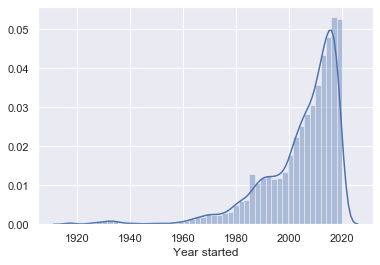

In [68]:
sns.distplot(mal_eda_df['Year started']);

In [69]:
mal_df_tv = mal_eda_df[mal_eda_df['Type'] == 'TV']
mal_df_movie = mal_eda_df[mal_eda_df['Type'] == 'Movie']
mal_df_ova = mal_eda_df[mal_eda_df['Type'] == 'OVA']
mal_df_ona = mal_eda_df[mal_eda_df['Type'] == 'ONA']

#mal_test_df = mal_test_df[mal_test_df['Type'] == 'TV']

In [70]:
mal_eda_df['Total length'] = mal_df['Episodes'] * mal_df['Duration']
mal_test_df['Total length'] = mal_test_df['Episodes'] * mal_test_df['Duration']

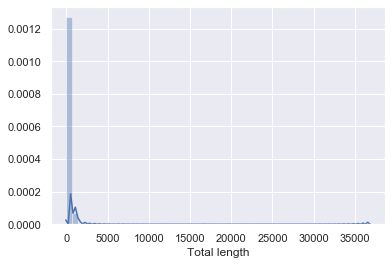

In [71]:
sns.distplot(mal_eda_df['Total length']);

In [72]:
mal_eda_df['Total length'].describe()

count    12776.000000
mean       207.897542
std        602.303681
min          0.000000
25%         12.000000
50%         50.000000
75%        207.250000
max      36775.000000
Name: Total length, dtype: float64

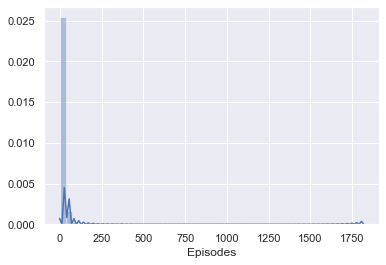

In [73]:
sns.distplot(mal_eda_df['Episodes']);

In [74]:
mal_eda_df['Episodes'].sort_values(ascending=False).head(20)

8935     1818.0
12184    1565.0
7809     1471.0
8337     1428.0
12183    1306.0
13744    1006.0
10417     744.0
7685      726.0
4169      694.0
6380      526.0
13131     510.0
375       500.0
13154     475.0
12044     425.0
14438     398.0
956       373.0
826       366.0
9318      365.0
12574     365.0
925       358.0
Name: Episodes, dtype: float64

In [75]:
mal_eda_df[mal_eda_df['Episodes'] >= 200].Episodes.count()

47

In [76]:
mal_eda_df[mal_eda_df['Episodes'] < 200].Episodes.sort_values().tail(20)

13415    156.0
14612    156.0
10578    156.0
885      161.0
13979    162.0
5333     164.0
727      167.0
5098     170.0
5173     170.0
6979     170.0
2268     172.0
743      175.0
1863     178.0
10674    180.0
2901     180.0
4084     182.0
2752     191.0
3142     192.0
11921    195.0
11179    199.0
Name: Episodes, dtype: float64

In [77]:
mal_eda_df['Clipped episodes'] = mal_eda_df['Episodes'].clip(0,200)
mal_test_df['Clipped episodes'] = mal_test_df['Episodes'].clip(0,200)

In [78]:
mal_eda_df[mal_eda_df['Type'] == 'Movie']['Duration'].sort_values()

7569       0
14080      0
13686      0
13198      0
3033       0
        ... 
3069     153
235      156
3880     163
14429    167
10488    231
Name: Duration, Length: 2268, dtype: int64

In [79]:
mal_eda_df.iloc[152]['Duration']

24

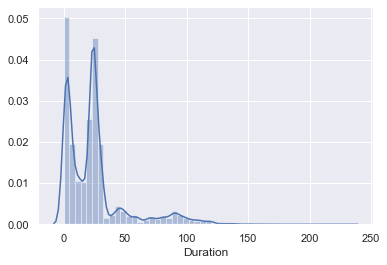

In [80]:
sns.distplot(mal_eda_df['Duration']);

In [81]:
mal_df_movie['Duration'].value_counts()

0      88
90     77
3      64
5      63
4      58
       ..
137     1
141     1
153     1
163     1
152     1
Name: Duration, Length: 145, dtype: int64

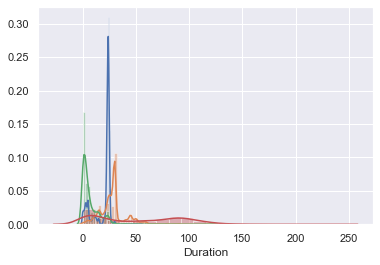

In [82]:
sns.distplot(mal_df_tv['Duration'], norm_hist=True)
sns.distplot(mal_df_ova['Duration'], norm_hist=True)
sns.distplot(mal_df_ona['Duration'], norm_hist=True)
sns.distplot(mal_df_movie['Duration'], norm_hist=True);

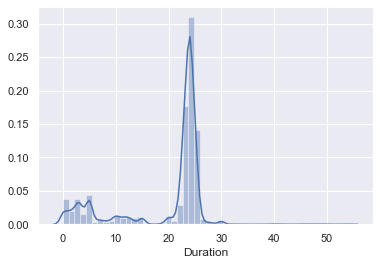

In [83]:
sns.distplot(mal_df_tv['Duration']);

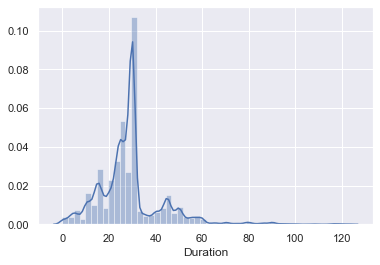

In [84]:
sns.distplot(mal_df_ova['Duration']);

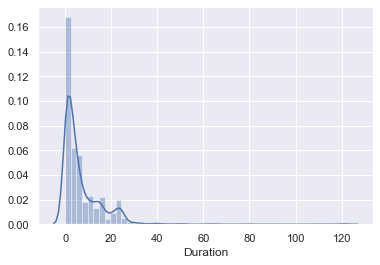

In [85]:
sns.distplot(mal_df_ona['Duration']);

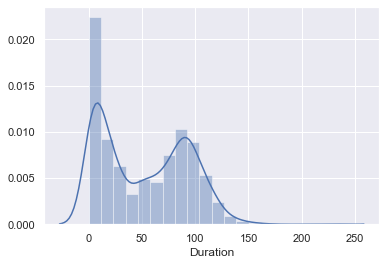

In [86]:
sns.distplot(mal_df_movie['Duration']);

In [87]:
mal_eda_df['Clipped duration'] = mal_eda_df['Duration'].clip(0,150)
mal_test_df['Clipped duration'] = mal_test_df['Duration'].clip(0,150)

In [88]:
mal_eda_df['Clipped length'] = mal_eda_df['Clipped duration'] * mal_eda_df['Clipped duration']
mal_test_df['Clipped length'] = mal_test_df['Clipped duration'] * mal_test_df['Clipped duration']

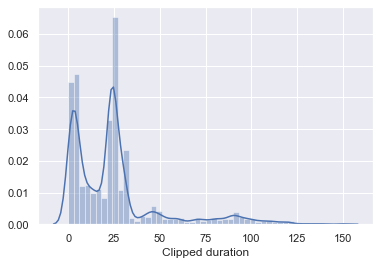

In [89]:
sns.distplot(mal_eda_df['Clipped duration']);

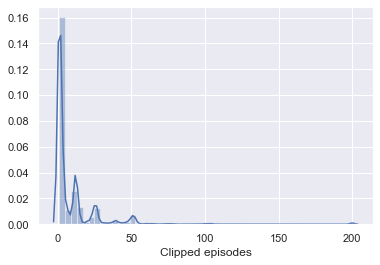

In [90]:
sns.distplot(mal_eda_df['Clipped episodes']);

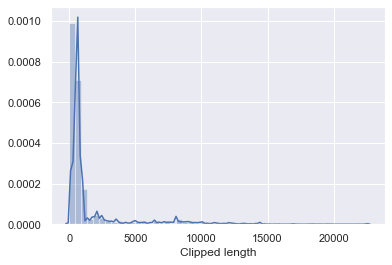

In [91]:
sns.distplot(mal_eda_df['Clipped length']);

In [92]:
mal_df_type_dummy.columns

Index(['Movie Type', 'Music Type', 'ONA Type', 'OVA Type', 'Special Type',
       'TV Type', 'Unknown Type'],
      dtype='object')

In [93]:
mal_columns = ['Score', 'Year started', 'Duration', 'Episodes', 'Rating score', 'Associated Count', 'Members', 'Favorites']

In [94]:
mal_df_mvp = mal_eda_df[mal_columns]

In [95]:
mal_df_mvp.head(5)

Score  Year started  Duration  Episodes  Rating score  Associated Count  \
0   9.23          2009        24      64.0             3                 4   
2   9.12          2015        24      51.0             2                 6   
3   9.12          2011        23     148.0             2                 6   
4   9.11          1988        26     110.0             3                 8   
5   9.10          2011        24      51.0             2                 3   

   Members  Favorites  
0  1739484     148909  
2   305233       8270  
3  1159669     104155  
4   186530      11731  
5   295318       5409

In [96]:
#sns.pairplot(mal_df_mvp, plot_kws=dict(alpha=.1, edgecolor='none'));

In [97]:
mal_eda_df.columns

Index(['Title', 'URL', 'English', 'Synonyms', 'Japanese', 'Type', 'Episodes',
       'Status', 'Aired', 'Premiered', 'Broadcast', 'Producers', 'Licensors',
       'Studios', 'Source', 'Genres', 'Duration', 'Rating', 'Score', 'Ranked',
       'Popularity', 'Members', 'Favorites', 'Started', 'Ended', 'Voters',
       'Adaptation', 'Alternative version', 'Side story', 'Spin-off',
       'Alternative setting', 'Sequel', 'Other', 'Prequel', 'Character',
       'Parent story', 'Summary', 'Full story', 'Movie Type', 'Music Type',
       'ONA Type', 'OVA Type', 'Special Type', 'TV Type', 'Unknown Type',
       'Action Genre', 'Adventure Genre', 'Cars Genre', 'Comedy Genre',
       'Dementia Genre', 'Demons Genre', 'Drama Genre', 'Ecchi Genre',
       'Fantasy Genre', 'Game Genre', 'Harem Genre', 'Hentai Genre',
       'Historical Genre', 'Horror Genre', 'Kids Genre', 'Magic Genre',
       'Mecha Genre', 'Military Genre', 'Music Genre', 'Mystery Genre',
       'Parody Genre', 'Psychological Gen

In [136]:
mal_type_cols = mal_df_type_dummy.columns.to_list()

mal_type_cols_less1 = [mal_type for mal_type in mal_type_cols if mal_type not in ['TV Genre', 'Unknown Genre']]

mal_features = ['Year started', 'UNIX started', 'Clipped duration', 'Clipped episodes', 'Clipped length', 'Genre Count', 'Rating score', 'Members', 'Favorites', 'Voters'] + mal_type_cols + mal_associated_counts_col + mal_genre_cons_list # R^2 = 0.52
mal_features_target = ['Score'] + mal_features

mal_train_df = mal_eda_df[mal_features_target].dropna()
X = mal_train_df.loc[:,mal_features]
y = mal_train_df['Score']

In [99]:
mal_train_df

Score  Year started  UNIX started  Clipped duration  Clipped episodes  \
0       9.23          2009  1.238890e+09                24              64.0   
2       9.12          2015  1.428451e+09                24              51.0   
3       9.12          2011  1.317514e+09                23             148.0   
4       9.11          1988  5.685984e+08                26             110.0   
5       9.10          2011  1.301875e+09                24              51.0   
...      ...           ...           ...               ...               ...   
16658   4.66          1987  5.488992e+08                30               1.0   
16659   4.63          2017  1.487894e+09                30               2.0   
16660   4.58          2001  9.961920e+08                22               1.0   
16661   4.57          2001  1.008374e+09                21               1.0   
16663   3.02          2002  1.028938e+09                23               1.0   

       Clipped length  Genre Count  Rating score  Members  Favorites  ...  \
0                 576            8             3  1739484     148909  ...   
2                 576            7             2   305233       8270  ...   
3                 529            5             2  1159669     104155  ...   
4                 676            4             3   186530      11731  ...   
5                 576            7             2   295318       5409  ...   
...               ...          ...           ...      ...        ...  ...   
16658             900            3             5      840          0  ...   
16659             900            1             5     2340          2  ...   
16660             484            1             5     1080          3  ...   
16661             441            1             5     1285          6  ...   
16663             529            1             5     1936         12  ...   

       Mystery Genre  Parody Genre  Psychological Genre  Romance Genre  \
0                  0             0                    0              0   
2                  0             0                    0              0   
3                  0             0                    0              0   
4                  0             0                    0              0   
5                  0             0                    0              0   
...              ...           ...                  ...            ...   
16658              0             0                    0              0   
16659              0             0                    0              0   
16660              0             0                    0              0   
16661              0             0                    0              0   
16663              0             0                    0              0   

       School Genre  Sci-Fi Genre  Slice of Life Genre  Space Genre  \
0                 0             0                    0            0   
2                 0             0                    0            0   
3                 0             0                    0            0   
4                 0             0                    0            0   
5                 0             0                    0            0   
...             ...           ...                  ...          ...   
16658             0             0                    0            0   
16659             0             0                    0            0   
16660             0             0                    0            0   
16661             0             0                    0            0   
16663             0             0                    0            0   

       Sports Genre  Supernatural Genre  
0                 0                   0  
2                 0                   0  
3                 0                   0  
4                 0                   0  
5                 0                   0  
...             ...                 ...  
16658             0                   0  
16659             0                   0  
1

In [100]:
def LinearRegressionCV(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

    return lr_model

In [137]:
lr_model_default = LinearRegressionCV(X, y)


Validation R^2 score was: 0.5186776767086956
Feature coefficient results: 

Year started : -0.06
UNIX started : 0.00
Clipped duration : 0.02
Clipped episodes : 0.01
Clipped length : -0.00
Genre Count : 0.05
Rating score : -0.02
Members : 0.00
Favorites : -0.00
Voters : -0.00
Movie Type : -0.03
Music Type : -0.03
ONA Type : -0.12
OVA Type : -0.06
Special Type : 0.15
TV Type : 0.09
Unknown Type : -0.00
Sequel Count : 0.26
Alternative version Count : 0.24
Adaptation Count : 0.27
Other Count : 0.17
Prequel Count : 0.37
Parent story Count : 0.49
Side story Count : 0.11
Spin-off Count : 0.17
Associated Count : -0.14
Action Genre : 0.30
Adventure Genre : 0.47
Cars Genre : 0.41
Comedy Genre : 0.44
Dementia Genre : -0.29
Demons Genre : 0.16
Drama Genre : 0.60
Ecchi Genre : 0.09
Fantasy Genre : 0.31
Game Genre : 0.28
Harem Genre : 0.29
Hentai Genre : 0.39
Historical Genre : 0.47
Horror Genre : -0.24
Kids Genre : 0.38
Magic Genre : 0.32
Mecha Genre : 0.30
Military Genre : 0.55
Music Genre : 0.39

In [139]:
mal_train_df['Log episodes'] = np.log10(mal_train_df['Clipped episodes'] + 1)
mal_train_df['Log duration'] = np.log10(mal_train_df['Clipped duration'] + 1)
mal_train_df['Log length'] = np.log10(mal_train_df['Clipped length'] + 1)
mal_train_df['Log assoc count'] = np.log10(mal_train_df['Associated Count'] + 1)
mal_train_df['Log members'] = np.log10(mal_train_df['Members'] + 1)
mal_train_df['Log favorites'] = np.log10(mal_train_df['Favorites'] + 1)
mal_train_df['Log fav over log members'] = mal_train_df['Log favorites'] / mal_train_df['Log members']
mal_train_df['Log UNIX started'] = np.log10(mal_train_df['UNIX started'])
mal_train_df['Sqrt year started'] = np.sqrt(mal_train_df['Year started'])

mal_test_df['Log episodes'] = np.log10(mal_test_df['Clipped episodes'] + 1)
mal_test_df['Log duration'] = np.log10(mal_test_df['Clipped duration'] + 1)
mal_test_df['Log length'] = np.log10(mal_test_df['Clipped length'] + 1)
mal_test_df['Log assoc count'] = np.log10(mal_test_df['Associated Count'] + 1)
mal_test_df['Log members'] = np.log10(mal_test_df['Members'] + 1)
mal_test_df['Log favorites'] = np.log10(mal_test_df['Favorites'] + 1)
mal_test_df['Log fav over log members'] = mal_test_df['Log favorites'] / mal_test_df['Log members']
mal_test_df['Log UNIX started'] = np.log10(mal_test_df['UNIX started'])
mal_test_df['Sqrt year started'] = np.sqrt(mal_test_df['Year started'])

#mal_train_transform_df = mal_train_df.drop(columns=['Episodes', 'Members', 'Favorites'])

In [140]:
mal_typelen_cols = [anime_type + " length" for anime_type in mal_type_cols]
mal_typeloglen_cols = [anime_type + " length" for anime_type in mal_type_cols]

for anime_type in mal_type_cols:
    mal_train_df[anime_type + " length"] = mal_train_df[anime_type] * mal_train_df['Clipped length']
    mal_train_df[anime_type + " log length"] = mal_train_df[anime_type] * mal_train_df['Log length']

mal_train_df['TV Type length']

0        576
2        576
3        529
4          0
5        576
        ... 
16658      0
16659      0
16660      0
16661      0
16663      0
Name: TV Type length, Length: 9180, dtype: int64

In [104]:
mal_test_df.describe()

Episodes     Duration        Score       Members      Favorites  \
count  3182.000000  3246.000000  2263.000000  3.246000e+03    3246.000000   
mean     12.896606    24.979051     6.608926  3.000864e+04     380.805299   
std      71.312285    25.370382     0.857429  1.006372e+05    3415.176195   
min       1.000000     0.000000     2.790000  1.600000e+01       0.000000   
25%       1.000000     5.000000     6.065000  2.970000e+02       0.000000   
50%       2.000000    23.000000     6.610000  1.796500e+03       3.000000   
75%      12.000000    28.000000     7.210000  1.354100e+04      31.000000   
max    3057.000000   162.000000     9.130000  1.880397e+06  124476.000000   

             Voters   Movie Type   Music Type     ONA Type     OVA Type  ...  \
count  2.263000e+03  3246.000000  3246.000000  3246.000000  3246.000000  ...   
mean   2.102141e+04     0.176833     0.070856     0.099199     0.232594  ...   
std    6.733391e+04     0.381586     0.256624     0.298975     0.422551  ...   
min    1.030000e+02     0.000000     0.000000     0.000000     0.000000  ...   
25%    4.740000e+02     0.000000     0.000000     0.000000     0.000000  ...   
50%    2.039000e+03     0.000000     0.000000     0.000000     0.000000  ...   
75%    1.224600e+04     0.000000     0.000000     0.000000     0.000000  ...   
max    1.264304e+06     1.000000     1.000000     1.000000     1.000000  ...   

       Clipped length  Log episodes  Log duration   Log length  \
count     3246.000000   3182.000000   3246.000000  3246.000000   
mean      1265.302526      0.713252      1.190344     2.305399   
std       2655.339663      0.506813      0.498373     1.055723   
min          0.000000      0.301030      0.000000     0.000000   
25%         25.000000      0.301030      0.778151     1.414973   
50%        529.000000      0.477121      1.380211     2.724276   
75%        784.000000      1.113943      1.462398     2.894870   
max      22500.000000      2.303196      2.178977     4.352202   

       Log assoc count  Log members  Log favorites  Log fav over log members  \
count      3246.000000  3246.000000    3246.000000               3246.000000   
mean          0.280834     3.368190       0.905992                  0.213886   
std           0.245582     1.018903       1.007932                  0.203145   
min           0.000000     1.230449       0.000000                  0.000000   
25%           0.000000     2.474216       0.000000                  0.000000   
50%           0.301030     3.254669       0.602060                  0.180044   
75%           0.477121     4.131682       1.505150                  0.370503   
max           1.763428     6.274250       5.095089                  0.828101   

       Log10 UNIX started  Sqrt year started  
count         3151.000000        3246.000000  
mean                 -inf          44.771395  
std                   NaN           0.166640  
min                  -inf          43.783559  
25%              8.978400          44.698993  
50%              9.101699          44.821870  
75%              9.157497          44.888751  
max              9.200505          44.944410  

[8 rows x 69 columns]

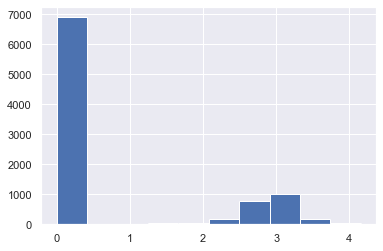

In [122]:
mal_train_df['OVA Type length'].hist();

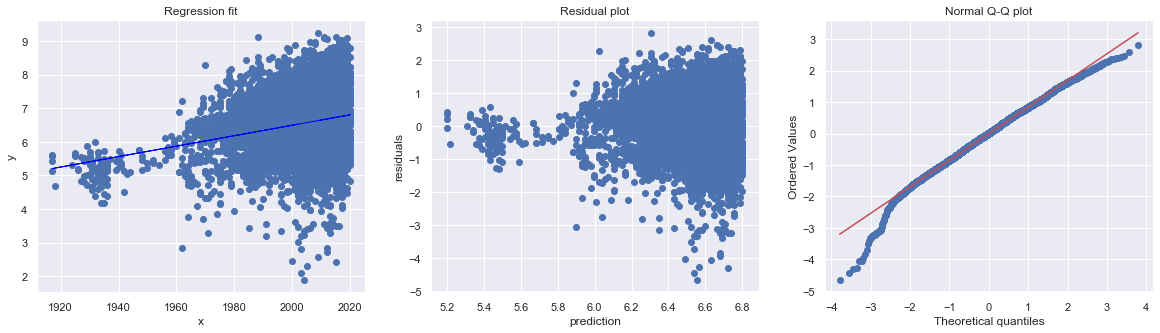

In [159]:
diagnostic_plot(mal_train_df.loc[:,['Year started']], mal_train_df['Score'])

In [169]:
mal_features_trans = mal_features + ['Log episodes', 'Log duration', 'Log members', 'Log favorites', 'Log fav over log members', 'Log assoc count', 'Sqrt year started'] # R^2 = 0.69

#mal_features_limit = ['Log fav over log members', 'Sqrt year started'] + mal_typeloglen_cols + mal_associated_counts_col + mal_genre_cons_list # R^2 = 0.64

#mal_features_limit = ['Log episodes', 'Log duration', 'Log members', 'Log favorites', 'Year started'] + mal_typeloglen_cols + mal_associated_counts_col + mal_genre_cons_list # R^2 = 0.66 

#mal_features_limit = ['Log episodes', 'Log duration', 'Log fav over log members', 'Sqrt year started'] + mal_typelen_cols + mal_associated_counts_col + mal_genre_cons_list # R^2 = 0.66

#mal_features_limit = ['Log episodes', 'Log duration', 'Log fav over log members', 'Sqrt year started', 'Genre Count'] + mal_typeloglen_cols + mal_associated_counts_col + mal_genre_cons_list # R^2 = 0.66

X = mal_train_df.loc[:,mal_features_limit]
y = mal_train_df['Score']

In [107]:
mal_train_df.columns

Index(['Score', 'Year started', 'UNIX started', 'Clipped duration',
       'Clipped episodes', 'Clipped length', 'Genre Count', 'Rating score',
       'Members', 'Favorites', 'Voters', 'Movie Type', 'Music Type',
       'ONA Type', 'OVA Type', 'Special Type', 'TV Type', 'Unknown Type',
       'Sequel Count', 'Alternative version Count', 'Adaptation Count',
       'Other Count', 'Prequel Count', 'Parent story Count',
       'Side story Count', 'Spin-off Count', 'Associated Count',
       'Action Genre', 'Adventure Genre', 'Cars Genre', 'Comedy Genre',
       'Dementia Genre', 'Demons Genre', 'Drama Genre', 'Ecchi Genre',
       'Fantasy Genre', 'Game Genre', 'Harem Genre', 'Hentai Genre',
       'Historical Genre', 'Horror Genre', 'Kids Genre', 'Magic Genre',
       'Mecha Genre', 'Military Genre', 'Music Genre', 'Mystery Genre',
       'Parody Genre', 'Psychological Genre', 'Romance Genre', 'School Genre',
       'Sci-Fi Genre', 'Slice of Life Genre', 'Space Genre', 'Sports Genre',
   

In [170]:
lr_model_mod = LinearRegressionCV(X, y)


Validation R^2 score was: 0.6427824856633437
Feature coefficient results: 

Log fav over log members : 2.91
Sqrt year started : 0.45
Movie Type length : 0.00
Music Type length : 0.00
ONA Type length : 0.00
OVA Type length : 0.00
Special Type length : 0.00
TV Type length : 0.00
Unknown Type length : 0.00
Sequel Count : 0.23
Alternative version Count : 0.25
Adaptation Count : 0.16
Other Count : 0.19
Prequel Count : 0.42
Parent story Count : 0.57
Side story Count : 0.17
Spin-off Count : 0.17
Associated Count : -0.17
Action Genre : 0.11
Adventure Genre : 0.27
Cars Genre : 0.10
Comedy Genre : 0.17
Dementia Genre : -0.57
Demons Genre : -0.17
Drama Genre : 0.29
Ecchi Genre : -0.20
Fantasy Genre : 0.09
Game Genre : 0.07
Harem Genre : -0.08
Hentai Genre : -0.15
Historical Genre : 0.22
Horror Genre : -0.48
Kids Genre : 0.32
Magic Genre : 0.13
Mecha Genre : 0.17
Military Genre : 0.28
Music Genre : 0.10
Mystery Genre : 0.29
Parody Genre : 0.16
Psychological Genre : -0.31
Romance Genre : 0.06
Scho

In [109]:
ridge_model = RidgeCV()
ridge_model.fit(X, y)

print(ridge_model.coef_)
print(ridge_model.score(X, y))

[ 0.27413429 -0.04416591  2.79458544  0.56296517  0.2565379   0.40563039
  0.18629864  0.18251175  0.31379417  0.12533334  0.          0.2258389
  0.2269015   0.16746191  0.19290743  0.39216252  0.50358763  0.16154997
  0.15604316 -0.16706315  0.04198038  0.19412216  0.15176784  0.13952783
 -0.48133699 -0.27174773  0.23657051 -0.22088948  0.05055749  0.03468163
 -0.11304279 -0.22120294  0.15357225 -0.36718717  0.25741328  0.0921837
  0.14866787  0.15261537  0.11485026  0.17943857  0.19774464 -0.27728062
  0.02883988  0.29291505  0.00797095  0.23747362 -0.08653679  0.1528092
 -0.02764024]
0.6644734673629757


In [110]:
lasso_model = LassoCV()
lasso_model.fit(X, y)

print(lasso_model.coef_)
print(lasso_model.score(X, y))

[ 2.63152000e-01  3.34479931e-01  2.78519368e+00  5.37081999e-01
  7.36919978e-02  2.14365255e-01  4.09143170e-03  0.00000000e+00
  1.33208194e-01 -5.07579676e-02  0.00000000e+00  1.45111344e-01
  1.49178553e-01  9.75876108e-02  1.15817700e-01  3.22617848e-01
  4.26532762e-01  8.29531685e-02  7.07267844e-02 -8.78243807e-02
 -2.09581816e-02  1.21244406e-01  0.00000000e+00  7.13104619e-02
 -5.30492131e-01 -2.12989543e-01  1.59783703e-01 -2.39581539e-01
 -0.00000000e+00 -0.00000000e+00 -1.31220937e-01 -2.78079893e-01
  1.65925529e-02 -3.42608040e-01  1.47231179e-01  0.00000000e+00
  2.07669119e-03  1.11909693e-02  3.49569495e-02  7.64006029e-02
  1.71153503e-02 -2.02162825e-01 -0.00000000e+00  4.55579096e-02
 -4.21542923e-02  1.62618089e-01 -0.00000000e+00  2.75000433e-02
 -0.00000000e+00]
0.6626839750192932


In [111]:

mal_test_cols = ["Score"] + mal_features_limit
mal_test_df = mal_test_df[mal_test_cols].dropna()
test_X = mal_test_df.loc[:,mal_features_limit]
test_y = mal_test_df['Score']

lr_model_mod.score(test_X, test_y)


KeyError: "['TV Type length', 'Special Type length', 'Movie Type length', 'OVA Type length', 'ONA Type length', 'Music Type length', 'Unknown Type length'] not in index"